Machine Learning in Options Pricing

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import matplotlib.pyplot as plt


In [2]:
# Black-Scholes pricing formula for European call options
def black_scholes_price(S, K, r, T, sigma, q):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price

# Function to generate synthetic option pricing data
def generate_data(num_samples):
    S = np.random.uniform(50, 150, num_samples)  # Spot price
    K = np.random.uniform(50, 150, num_samples)  # Strike price
    r = np.random.uniform(0.01, 0.05, num_samples)  # Risk-free rate
    T = np.random.uniform(0.1, 2.0, num_samples)  # Time to maturity
    sigma = np.random.uniform(0.1, 0.5, num_samples)  # Volatility
    q = np.random.uniform(0.01, 0.03, num_samples)  # Dividend yield
    historical_volatility = np.random.uniform(0.1, 0.5, num_samples)  # Historical volatility

    # Compute Black-Scholes option prices
    prices = black_scholes_price(S, K, r, T, sigma, q)

    # Feature engineering - interaction terms
    interaction_term1 = S * K
    interaction_term2 = sigma * T

    # Create DataFrame
    data = pd.DataFrame({
        'S': S,
        'K': K,
        'r': r,
        'T': T,
        'sigma': sigma,
        'q': q,
        'Historical_Volatility': historical_volatility,
        'Interaction_Term1': interaction_term1,
        'Interaction_Term2': interaction_term2,
        'Price': prices
    })

    return data

# Generate dataset
data = generate_data(10000)

# Define features and target
X = data[['S', 'K', 'r', 'T', 'sigma', 'q', 'Historical_Volatility', 'Interaction_Term1', 'Interaction_Term2']]
y = data['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
# Custom loss function to handle relative error
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred) / (tf.abs(y_true) + 1e-6))

# Build the neural network model
input_layer = tf.keras.Input(shape=(X_train_scaled.shape[1],))

x = tf.keras.layers.Dense(128)(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

# Residual connection
residual_input = x
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Add()([x, residual_input])  # Skip connection

x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

output_layer = tf.keras.layers.Dense(1)(x)

# Create model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=custom_loss)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_scaled, y_train.values.reshape(-1, 1),
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate on test set
test_loss = model.evaluate(X_test_scaled, y_test.values.reshape(-1, 1))
print(f'Test Loss: {test_loss}')

# Function to predict option price
def predict_option_price(S, K, r, T, sigma, q, historical_volatility):
    input_data = np.array([[S, K, r, T, sigma, q, historical_volatility, S*K, sigma*T]])
    input_scaled = scaler.transform(input_data)
    predicted_price = model.predict(input_scaled)
    return predicted_price[0][0]

# Example prediction
predicted_price = predict_option_price(100, 100, 0.03, 1.5, 0.25, 0.02, 0.3)
print(f'Predicted Option Price: {predicted_price}')

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8036.1929 - val_loss: 988.2505
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2906.7659 - val_loss: 819.7363
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1937.5485 - val_loss: 671.4893
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1002.8550 - val_loss: 647.9583
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 849.0007 - val_loss: 418.4673
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 659.8831 - val_loss: 265.7279
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 493.0130 - val_loss: 210.5724
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 379.2553 - val_loss: 154.4019
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 457.4370 - val_loss: 147.5862
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 352.0147 - val_loss: 127.5307
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 188.5480 - val_loss: 83

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


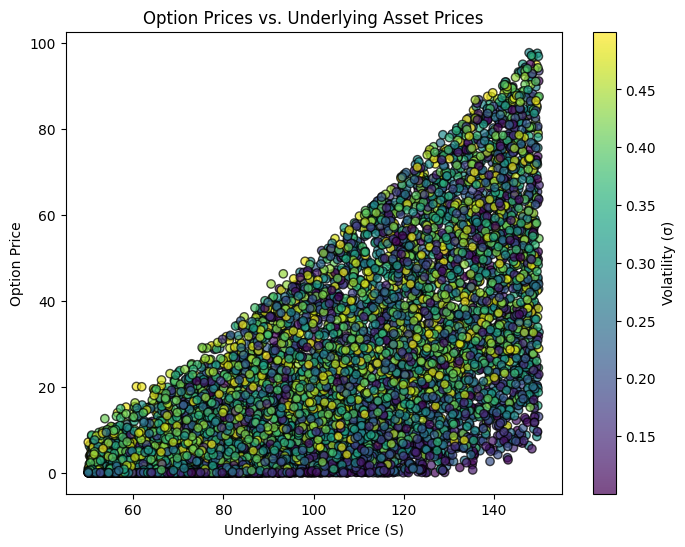

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(data['S'], data['Price'], c=data['sigma'], cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(label='Volatility (σ)')
plt.title("Option Prices vs. Underlying Asset Prices")
plt.xlabel("Underlying Asset Price (S)")
plt.ylabel("Option Price")
plt.show()

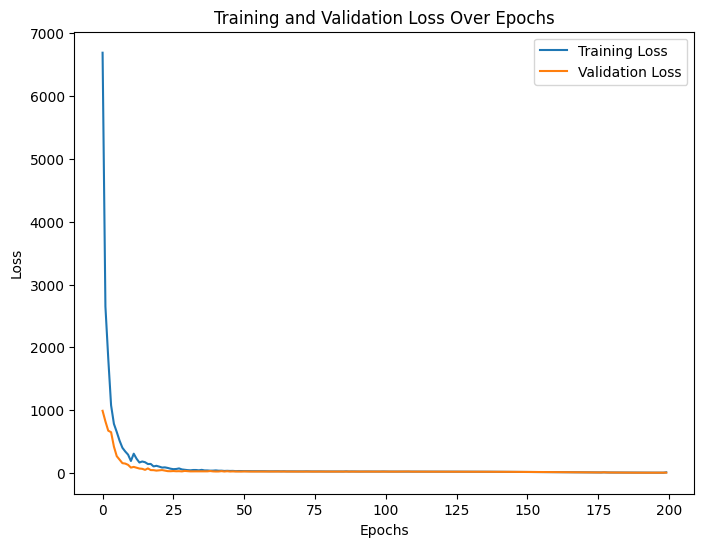

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.show()